In [1]:
yaml_content = """
wandb:
  parameters:
    mode: "online"
    entity: "nhtnam"
    project: "segformer3d_epa_acdc"
    resume: "must"
model:
  name: "segformer3d_epa_acdc"
  parameters:
    in_channels: 1
    embed_dims: [32, 64, 160, 256]
    patch_kernel_size: [7, 3, 3, 3]
    patch_stride: [4, 2, 2, 2]
    patch_padding: [3, 1, 1, 1]
    mlp_ratios: [4, 4, 4, 4]
    num_heads: [1, 2, 5, 8]
    depths: [2, 2, 2, 2]
    num_classes: 3
    decoder_dropout: 0.0
    decoder_head_embedding_dim: 256
loss_fn:
  loss_type: "dice"
  loss_args: None

optimizer:
  optimizer_type: "adamw"
  optimizer_args:
    lr: 0.0001
    weight_decay: 0.01

warmup_scheduler:
  enabled: True 
  warmup_epochs: 20

train_scheduler:
  scheduler_type: 'cosine_annealing_wr'
  scheduler_args:
    t_0_epochs: 20
    t_mult: 1
    min_lr: 0.000006

sliding_window_inference:
  sw_batch_size: 8
  roi: [6, 96, 96]

training_parameters:
  seed: 42
  num_epochs: 9000
  start_epoch: 0
  load_optimizer: False
  print_every: 400
  calculate_metrics: True
  grad_accumulate_steps: 2


dataset:
  name: "acdc"
  train_dataset:
    root: "/kaggle/input/acdc-processed/processed"
    train: True

  val_dataset:
    root: "/kaggle/input/acdc-processed/processed"
    train: False

  train_dataloader:
    batch_size: 64
    shuffle: True
    num_workers: 4
    drop_last: True

  val_dataloader:
    batch_size: 1
    shuffle: False
    num_workers: 1
    drop_last: False
"""

In [2]:
import wandb
wandb.login(key="1933072940bf436f5dd1e1a14a672b93cbc017c6")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nhatnamit214 (nhtnam) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# **utils.py**

In [3]:
!pip install monai
import os
import torch
import imageio
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from monai.data import MetaTensor
from sklearn.preprocessing import MinMaxScaler 
from monai.transforms import (
    Orientation, 
    EnsureType,
)
import yaml
import random
from PIL import Image
def load_nifti(fp:str) -> list:
    """
    Load a NIfTI file and return its data array and affine matrix.
    
    Parameters:
        fp (str): Path to the NIfTI file (.nii or .nii.gz).
    
    Returns:
        tuple: (nifti_scan, affine) if successful, otherwise None.
    """
    if not os.path.exists(fp):
        raise FileNotFoundError(f"File {fp} does not exist.")
    
    try:
        nifti_data = nib.load(fp)
        nifti_scan = nifti_data.get_fdata() 
        affine = nifti_data.affine 
        return nifti_scan, affine
    except Exception as e:
        raise RuntimeError(f"Error loading NIfTI file {fp}: {e}")
def load_modalities(file_path: str):
    """
    Load the modalities tensor from a .pt file.

    Args:
        file_path (str): Đường dẫn tới file .pt

    Returns:
        torch.Tensor hoặc None nếu có lỗi.
    """
    try:
        modalities = torch.load(file_path, map_location=torch.device("cpu"), weights_only=False)
        return modalities
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None
def detach_meta(x: MetaTensor) -> np.ndarray:
        if not isinstance(x, MetaTensor):
            raise TypeError("Input to `detach_meta` must be a MetaTensor.")
        return EnsureType(data_type="numpy", track_meta=False)(x)
def orient(x: MetaTensor) -> MetaTensor:
        if not isinstance(x, MetaTensor):
            raise TypeError("Input to `orient` must be a MetaTensor.")
        return Orientation(axcodes="RAS")(x)   
def normalize(x: np.ndarray) -> np.ndarray:
        try:
            scaler = MinMaxScaler(feature_range=(0, 1))
            normalized_1D_array = scaler.fit_transform(x.reshape(-1, x.shape[-1]))
            return normalized_1D_array.reshape(x.shape)
        except ValueError as e:
            raise ValueError(f"Error in normalization: {e}")
def generate_gif(x: np.ndarray, fp: str):
    imageio.mimsave(fp, (x * 255).astype(np.uint8), duration=0.1)
     
def seed_everything(seed) -> None:
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def load_config(config_path: str) -> dict:
    """loads the yaml config file

    Args:
        config_path (str): _description_

    Returns:
        Dict: _description_
    """
    with open(config_path, "r") as file:
        config = yaml.safe_load(file)
    return config
def visualize_result(volume, prediction, slice_idx, title):
    # volume: 3, D, H, W
    # prediction: 3, D, H, W
    D, H, W = volume.shape[1:]

    # Initialize a list to store overlayed images
    overlay_all_slices = []

    # Extract the flair modality and the prediction for the given slice
    flair_slice = volume[0, slice_idx, :, :]  # (H, W) - Flair modality
    prediction_slice = prediction[:, slice_idx, :, :]  # (3, H, W)

    # Extract WT, TC, ET masks
    wt_mask = prediction_slice[1, :, :]  # Channel 2: Whole Tumor (WT)
    tc_mask = prediction_slice[0, :, :]  # Channel 1: Tumor Core (TC)
    et_mask = prediction_slice[2, :, :]  # Channel 3: Enhancing Tumor (ET)

    # Overlay masks in priority order: ET > TC > WT
    final_mask = np.zeros_like(wt_mask)

    final_mask[et_mask > 0] = 3  # ET
    final_mask[(tc_mask > 0) & (final_mask == 0)] = 2  # TC
    final_mask[(wt_mask > 0) & (final_mask == 0)] = 1  # WT

    # Convert the flair slice to a 3-channel color image
    flair_slice_color = np.stack((flair_slice,) * 3, axis=-1)  # (H, W, 3)

    # Apply RGB overlays
    flair_slice_color[final_mask == 1] = [255, 0, 0]    # WT - Red
    flair_slice_color[final_mask == 2] = [0, 255, 0]    # TC - Green
    flair_slice_color[final_mask == 3] = [0, 0, 255]    # ET - Blue

    # Display the slice to check results
    plt.imshow(flair_slice_color)
    plt.title(title)
    plt.axis('off')
    plt.show()

def create_gif_from_volume(volume, prediction, modal=0, gif_path='output.gif', duration=0.1):
    """
    Create a GIF from all slices along the D dimension of the volume and prediction.
    - volume: tensor of shape (3, D, H, W)
    - prediction: tensor of shape (3, D, H, W)
    """
    _, D, H, W = volume.shape
    frames = []

    for slice_idx in range(D):
        flair_slice = volume[modal, slice_idx, :, :]
        prediction_slice = prediction[:, slice_idx, :, :]

        wt_mask = prediction_slice[1, :, :]
        tc_mask = prediction_slice[0, :, :]
        et_mask = prediction_slice[2, :, :]

        final_mask = np.zeros_like(wt_mask)
        final_mask[et_mask > 0] = 3
        final_mask[(tc_mask > 0) & (final_mask == 0)] = 2
        final_mask[(wt_mask > 0) & (final_mask == 0)] = 1

        flair_rgb = np.stack((flair_slice,) * 3, axis=-1)

        # Normalize and scale to [0, 255]
        max_val = flair_rgb.max()
        if max_val > 0:
            flair_rgb = np.clip(flair_rgb / max_val, 0, 1) * 255
        else:
            flair_rgb = np.zeros_like(flair_rgb)  # fallback to black image

        flair_rgb = flair_rgb.astype(np.uint8)

        # Apply color masks
        flair_rgb[final_mask == 1] = [255, 0, 0]  # WT - Red
        flair_rgb[final_mask == 2] = [0, 255, 0]  # TC - Green
        flair_rgb[final_mask == 3] = [0, 0, 255]  # ET - Blue

        # Convert to PIL image
        img_pil = Image.fromarray(flair_rgb)
        img_pil = img_pil.convert("RGB")

        # Optional: add text like "Slice: idx" using ImageDraw, ImageFont

        frames.append(img_pil)

    # Save as animated GIF
    frames[0].save(
        gif_path,
        save_all=True,
        append_images=frames[1:],
        duration=duration * 1000,
        loop=0
    )
    print(f"✅ GIF saved at: {gif_path}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 37.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existin

<frozen importlib._bootstrap_external>:1241: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
2025-06-07 03:21:38.570689: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749266498.800570      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749266498.868737      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import torch.nn as nn
import torch
import math
def init_(tensor):
    dim = tensor.shape[-1]
    std = 1 / math.sqrt(dim)
    tensor.uniform_(-std, std)
    return tensor
class EPA(nn.Module):
    """
        Efficient Paired Attention Block, based on: "Shaker et al.,
        UNETR++: Delving into Efficient and Accurate 3D Medical Image Segmentation"
        """
    def __init__(self, input_size, proj_size, embed_dim, num_heads=4, qkv_bias=False,
                 channel_attn_drop=0.1, spatial_attn_drop=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.temperature = nn.Parameter(torch.ones(num_heads, 1, 1))
        self.temperature2 = nn.Parameter(torch.ones(num_heads, 1, 1))

        # qkvv are 4 linear layers (query_shared, key_shared, value_spatial, value_channel)
        self.qkvv = nn.Linear(embed_dim, embed_dim * 4, bias=qkv_bias)

        # E and F are projection matrices with shared weights used in spatial attention module to project
        # keys and values from HWD-dimension to P-dimension
        self.EF = nn.Parameter(init_(torch.zeros(input_size, proj_size)))

        self.attn_drop = nn.Dropout(channel_attn_drop)
        self.attn_drop_2 = nn.Dropout(spatial_attn_drop)
        self.gamma = nn.Parameter(1e-6 * torch.ones(embed_dim), requires_grad=True)

    def forward(self, x):
        B, N, C = x.shape

        qkvv = self.qkvv(x).reshape(B, N, 4, self.num_heads, C // self.num_heads)
        qkvv = qkvv.permute(2, 0, 3, 1, 4)
        q_shared, k_shared, v_CA, v_SA = qkvv[0], qkvv[1], qkvv[2], qkvv[3]

        q_shared = q_shared.transpose(-2, -1)
        k_shared = k_shared.transpose(-2, -1)
        v_CA = v_CA.transpose(-2, -1)
        v_SA = v_SA.transpose(-2, -1)

        proj_e_f = lambda args: torch.einsum('bhdn,nk->bhdk', *args)
        k_shared_projected, v_SA_projected = map(proj_e_f, zip((k_shared, v_SA), (self.EF, self.EF)))

        q_shared = torch.nn.functional.normalize(q_shared, dim=-1)
        k_shared = torch.nn.functional.normalize(k_shared, dim=-1)

        attn_CA = (q_shared @ k_shared.transpose(-2, -1)) * self.temperature
        attn_CA = attn_CA.softmax(dim=-1)
        attn_CA = self.attn_drop(attn_CA)
        x_CA = (attn_CA @ v_CA).permute(0, 3, 1, 2).reshape(B, N, C)

        attn_SA = (q_shared.permute(0, 1, 3, 2) @ k_shared_projected) * self.temperature2
        attn_SA = attn_SA.softmax(dim=-1)
        attn_SA = self.attn_drop_2(attn_SA)
        x_SA = (attn_SA @ v_SA_projected.transpose(-2, -1)).permute(0, 3, 1, 2).reshape(B, N, C)

        return self.gamma*(x_CA + x_SA)

In [5]:
import torch
import math
from torch import nn
def build_segformer3d_model(config=None):
    model = SegFormer3D(
        in_channels=config["model"]["parameters"]["in_channels"],
        embed_dims=config["model"]["parameters"]["embed_dims"],
        patch_kernel_size=config["model"]["parameters"]["patch_kernel_size"],
        patch_stride=config["model"]["parameters"]["patch_stride"],
        patch_padding=config["model"]["parameters"]["patch_padding"],
        mlp_ratios=config["model"]["parameters"]["mlp_ratios"],
        num_heads=config["model"]["parameters"]["num_heads"],
        depths=config["model"]["parameters"]["depths"],
        decoder_head_embedding_dim=config["model"]["parameters"]["decoder_head_embedding_dim"],
        num_classes=config["model"]["parameters"]["num_classes"],
        decoder_dropout=config["model"]["parameters"]["decoder_dropout"],
    )
    return model


class SegFormer3D(nn.Module):
    def __init__(
        self,
        in_channels: int = 1,
        embed_dims: list = [32, 64, 160, 256],
        patch_kernel_size: list = [7, 3, 3, 3],
        patch_stride: list = [4, 2, 2, 2],
        patch_padding: list = [3, 1, 1, 1],
        mlp_ratios: list = [4, 4, 4, 4],
        num_heads: list = [1, 2, 5, 8],
        depths: list = [2, 2, 2, 2],
        decoder_head_embedding_dim: int = 256,
        num_classes: int = 3,
        decoder_dropout: float = 0.0,
    ):
        """
        in_channels: number of the input channels
        sr_ratios: the rates at which to down sample the sequence length of the embedded patch
        embed_dims: hidden size of the PatchEmbedded input
        patch_kernel_size: kernel size for the convolution in the patch embedding module
        patch_stride: stride for the convolution in the patch embedding module
        patch_padding: padding for the convolution in the patch embedding module
        mlp_ratios: at which rate increasse the projection dim of the hidden_state in the mlp
        num_heads: number of attention heads
        depths: number of attention layers
        decoder_head_embedding_dim: projection dimension of the mlp layer in the all-mlp-decoder module
        num_classes: number of the output channel of the network
        decoder_dropout: dropout rate of the concatenated feature maps
        """
        super().__init__()
        self.segformer_encoder = MixVisionTransformer(
            in_channels=in_channels,
            embed_dims=embed_dims,
            patch_kernel_size=patch_kernel_size,
            patch_stride=patch_stride,
            patch_padding=patch_padding,
            mlp_ratios=mlp_ratios,
            num_heads=num_heads,
            depths=depths,
        )
        reversed_embed_dims = embed_dims[::-1]
        self.segformer_decoder = SegFormerDecoderHead(
            input_feature_dims=reversed_embed_dims,
            decoder_head_embedding_dim=decoder_head_embedding_dim,
            num_classes=num_classes,
            dropout=decoder_dropout,
        )
   
    def forward(self, x):
        x = self.segformer_encoder(x)
        c1 = x[0]
        c2 = x[1]
        c3 = x[2]
        c4 = x[3]
        x = self.segformer_decoder(c1, c2, c3, c4)
        return x
    
# ----------------------------------------------------- encoder -----------------------------------------------------
class PatchEmbedding(nn.Module):
    def __init__(
        self,
        in_channel: int = 4,
        embed_dim: int = 768,
        kernel_size: int = 7,
        stride: int = 4,
        padding: int = 3,
    ):
        """
        in_channels: number of the channels in the input volume
        embed_dim: embedding dimmesion of the patch
        """
        super().__init__()
        self.patch_embeddings = nn.Conv3d(
            in_channel,
            embed_dim,
            kernel_size=(3, kernel_size, kernel_size),
            stride=(int(stride / 2), stride, stride),
            padding=(1, padding, padding)
        )
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        patches = self.patch_embeddings(x)
        _, _, D, H, W = patches.shape
        patches = patches.flatten(2).transpose(1, 2)
        patches = self.norm(patches)
        return patches, (D, H, W)

class TransformerBlock(nn.Module):
    def __init__(
        self,
        input_size: int,
        proj_size: int,
        embed_dim: int,
        num_heads: int = 4,
        mlp_ratio: int = 2,
        qkv_bias: bool = False,
        channel_attn_drop: float = 0.1,
        spatial_attn_drop: float = 0.1,
    ):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = EPA(
            input_size=input_size,
            proj_size=proj_size,
            embed_dim=embed_dim,
            num_heads = num_heads,
            qkv_bias=qkv_bias,
            channel_attn_drop=channel_attn_drop,
            spatial_attn_drop=spatial_attn_drop,
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = _MLP(in_feature=embed_dim, mlp_ratio=mlp_ratio, dropout=0.0)

    def forward(self, x, spatial_dims=None):
        x = x + self.attention(self.norm1(x))
        x = x + self.mlp(self.norm2(x), spatial_dims=spatial_dims)
        return x


class MixVisionTransformer(nn.Module):
    def __init__(
        self,
        in_channels: int = 4,
        embed_dims: list = [64, 128, 320, 512],
        patch_kernel_size: list = [7, 3, 3, 3],
        patch_stride: list = [4, 2, 2, 2],
        patch_padding: list = [3, 1, 1, 1],
        mlp_ratios: list = [2, 2, 2, 2],
        num_heads: list = [1, 2, 5, 8],
        depths: list = [2, 2, 2, 2],
    ):
        """
        in_channels: number of the input channels
        sr_ratios: the rates at which to down sample the sequence length of the embedded patch
        embed_dims: hidden size of the PatchEmbedded input
        patch_kernel_size: kernel size for the convolution in the patch embedding module
        patch_stride: stride for the convolution in the patch embedding module
        patch_padding: padding for the convolution in the patch embedding module
        mlp_ratios: at which rate increasse the projection dim of the hidden_state in the mlp
        num_heads: number of attenion heads
        depths: number of attention layers
        """
        super().__init__()
        self.embed_1 = PatchEmbedding(
            in_channel=in_channels,
            embed_dim=embed_dims[0],
            kernel_size=patch_kernel_size[0],
            stride=patch_stride[0],
            padding=patch_padding[0],
        )
        self.embed_2 = PatchEmbedding(
            in_channel=embed_dims[0],
            embed_dim=embed_dims[1],
            kernel_size=patch_kernel_size[1],
            stride=patch_stride[1],
            padding=patch_padding[1],
        )
        self.embed_3 = PatchEmbedding(
            in_channel=embed_dims[1],
            embed_dim=embed_dims[2],
            kernel_size=patch_kernel_size[2],
            stride=patch_stride[2],
            padding=patch_padding[2],
        )
        self.embed_4 = PatchEmbedding(
            in_channel=embed_dims[2],
            embed_dim=embed_dims[3],
            kernel_size=patch_kernel_size[3],
            stride=patch_stride[3],
            padding=patch_padding[3],
        )

        # block 1
        self.tf_block1 = nn.ModuleList(
            [
                TransformerBlock(
                    input_size=3*24*24,
                    proj_size= 32,
                    embed_dim=embed_dims[0],
                    num_heads=num_heads[0],
                    mlp_ratio=mlp_ratios[0],
                    qkv_bias=True,
                )
                for _ in range(depths[0])
            ]
        )
        self.norm1 = nn.LayerNorm(embed_dims[0])

        # block 2
        self.tf_block2 = nn.ModuleList(
            [
                TransformerBlock(
                    input_size=3*12*12,
                    proj_size= 32,
                    embed_dim=embed_dims[1],
                    num_heads=num_heads[1],
                    mlp_ratio=mlp_ratios[1],
                )
                for _ in range(depths[1])
            ]
        )
        self.norm2 = nn.LayerNorm(embed_dims[1])

        # block 3
        self.tf_block3 = nn.ModuleList(
            [
                TransformerBlock(
                    input_size=3*6*6,
                    proj_size= 32,
                    embed_dim=embed_dims[2],
                    num_heads=num_heads[2],
                    mlp_ratio=mlp_ratios[2],
                    qkv_bias=True,
                )
                for _ in range(depths[2])
            ]
        )
        self.norm3 = nn.LayerNorm(embed_dims[2])

        # block 4
        self.tf_block4 = nn.ModuleList(
            [
                TransformerBlock(
                    input_size=3*3*3,
                    proj_size=16,
                    embed_dim=embed_dims[3],
                    num_heads=num_heads[3],
                    mlp_ratio=mlp_ratios[3],
                    qkv_bias=True,
                )
                for _ in range(depths[3])
            ]
        )
        self.norm4 = nn.LayerNorm(embed_dims[3])

    def forward(self, x):
        out = []
        # at each stage these are the following mappings:
        # (batch_size, num_patches, hidden_state)
        # (num_patches,) -> (D, H, W)
        # (batch_size, num_patches, hidden_state) -> (batch_size, hidden_state, D, H, W)

        # stage 1
        x, (d1, h1, w1) = self.embed_1(x)
        B, _, _ = x.shape
        for blk in self.tf_block1:
            x = blk(x, spatial_dims=(d1, h1, w1))
        x = self.norm1(x)
        # (B, N, C) -> (B, D, H, W, C) -> (B, C, D, H, W)
        x = x.reshape(B, d1, h1, w1, -1).permute(0, 4, 1, 2, 3).contiguous()
        out.append(x)

        # stage 2
        x, (d2, h2, w2) = self.embed_2(x)
        B, _, _ = x.shape
        for blk in self.tf_block2:
            x = blk(x, spatial_dims=(d2, h2, w2))
        x = self.norm2(x)
        # (B, N, C) -> (B, D, H, W, C) -> (B, C, D, H, W)
        x = x.reshape(B, d2, h2, w2, -1).permute(0, 4, 1, 2, 3).contiguous()
        out.append(x)

        # stage 3
        x, (d3, h3, w3) = self.embed_3(x)
        B, _, _ = x.shape
        for blk in self.tf_block3:
            x = blk(x, spatial_dims=(d3, h3, w3))
        x = self.norm3(x)
        # (B, N, C) -> (B, D, H, W, C) -> (B, C, D, H, W)
        x = x.reshape(B, d3, h3, w3, -1).permute(0, 4, 1, 2, 3).contiguous()
        out.append(x)

        # stage 4
        x, (d4, h4, w4) = self.embed_4(x)
        B, _, _ = x.shape
        for blk in self.tf_block4:
            x = blk(x, spatial_dims=(d4, h4, w4))
        x = self.norm4(x)
        # (B, N, C) -> (B, D, H, W, C) -> (B, C, D, H, W)
        x = x.reshape(B, d4, h4, w4, -1).permute(0, 4, 1, 2, 3).contiguous()
        out.append(x)

        return out


class _MLP(nn.Module):
    def __init__(self, in_feature, mlp_ratio=2, dropout=0.0):
        super().__init__()
        out_feature = mlp_ratio * in_feature
        self.fc1 = nn.Linear(in_feature, out_feature)
        self.dwconv = DWConv(dim=out_feature)
        self.fc2 = nn.Linear(out_feature, in_feature)
        self.act_fn = nn.GELU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, spatial_dims=None):
        x = self.fc1(x)
        x = self.dwconv(x, spatial_dims=spatial_dims)
        x = self.act_fn(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x


class DWConv(nn.Module):
    def __init__(self, dim=768):
        super().__init__()
        self.dwconv = nn.Conv3d(dim, dim, 3, 1, 1, bias=True, groups=dim)
        self.bn = nn.BatchNorm3d(dim)

    def forward(self, x, spatial_dims=None):
        d, h, w = spatial_dims
        B, N, C = x.shape
        # (batch, num_patchs, hidden_size) -> (batch, hidden_size, D, H, W)
        # assuming D = H = W, i.e. cube root of the patch is an integer number!
        x = x.transpose(1, 2).view(B, C, d, h, w)
        x = self.dwconv(x)
        # added batchnorm (remove it ?)
        x = self.bn(x)
        x = x.flatten(2).transpose(1, 2)
        return x

###################################################################################
def cube_root(n):
    return round(math.pow(n, (1 / 3)))
    

###################################################################################
# ----------------------------------------------------- decoder -------------------
class MLP_(nn.Module):
    """
    Linear Embedding
    """

    def __init__(self, input_dim=2048, embed_dim=768):
        super().__init__()
        self.proj = nn.Linear(input_dim, embed_dim)
        self.bn = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = x.flatten(2).transpose(1, 2).contiguous()
        x = self.proj(x)
        x = self.bn(x)
        return x


###################################################################################
class SegFormerDecoderHead(nn.Module):
    """
    SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers
    """

    def __init__(
        self,
        input_feature_dims: list = [512, 320, 128, 64],
        decoder_head_embedding_dim: int = 256,
        num_classes: int = 3,
        dropout: float = 0.0,
    ):
        """
        input_feature_dims: list of the output features channels generated by the transformer encoder
        decoder_head_embedding_dim: projection dimension of the mlp layer in the all-mlp-decoder module
        num_classes: number of the output channels
        dropout: dropout rate of the concatenated feature maps
        """
        super().__init__()
        self.linear_c4 = MLP_(
            input_dim=input_feature_dims[0],
            embed_dim=decoder_head_embedding_dim,
        )
        self.linear_c3 = MLP_(
            input_dim=input_feature_dims[1],
            embed_dim=decoder_head_embedding_dim,
        )
        self.linear_c2 = MLP_(
            input_dim=input_feature_dims[2],
            embed_dim=decoder_head_embedding_dim,
        )
        self.linear_c1 = MLP_(
            input_dim=input_feature_dims[3],
            embed_dim=decoder_head_embedding_dim,
        )
        # convolution module to combine feature maps generated by the mlps
        self.linear_fuse = nn.Sequential(
            nn.Conv3d(
                in_channels=4 * decoder_head_embedding_dim,
                out_channels=decoder_head_embedding_dim,
                kernel_size=1,
                stride=1,
                bias=False,
            ),
            nn.BatchNorm3d(decoder_head_embedding_dim),
            nn.ReLU(),
        )
        self.dropout = nn.Dropout(dropout)

        # final linear projection layer
        self.linear_pred = nn.Conv3d(
            decoder_head_embedding_dim, num_classes, kernel_size=1
        )

        # segformer decoder generates the final decoded feature map size at 1/4 of the original input volume size
        self.upsample_volume = nn.Upsample(
            scale_factor=(2.0, 4.0, 4.0), mode="trilinear", align_corners=False
        )

    def forward(self, c1, c2, c3, c4):
       ############## _MLP decoder on C1-C4 ###########
        n, _, _, _, _ = c4.shape

        _c4 = (
            self.linear_c4(c4)
            .permute(0, 2, 1)
            .reshape(n, -1, c4.shape[2], c4.shape[3], c4.shape[4])
            .contiguous()
        )
        _c4 = torch.nn.functional.interpolate(
            _c4,
            size=c1.size()[2:],
            mode="trilinear",
            align_corners=False,
        )

        _c3 = (
            self.linear_c3(c3)
            .permute(0, 2, 1)
            .reshape(n, -1, c3.shape[2], c3.shape[3], c3.shape[4])
            .contiguous()
        )
        _c3 = torch.nn.functional.interpolate(
            _c3,
            size=c1.size()[2:],
            mode="trilinear",
            align_corners=False,
        )

        _c2 = (
            self.linear_c2(c2)
            .permute(0, 2, 1)
            .reshape(n, -1, c2.shape[2], c2.shape[3], c2.shape[4])
            .contiguous()
        )
        _c2 = torch.nn.functional.interpolate(
            _c2,
            size=c1.size()[2:],
            mode="trilinear",
            align_corners=False,
        )

        _c1 = (
            self.linear_c1(c1)
            .permute(0, 2, 1)
            .reshape(n, -1, c1.shape[2], c1.shape[3], c1.shape[4])
            .contiguous()
        )

        _c = self.linear_fuse(torch.cat([_c4, _c3, _c2, _c1], dim=1))

        x = self.dropout(_c)
        x = self.linear_pred(x)
        x = self.upsample_volume(x)
        return x

In [6]:
def build_architecture(config):
    if config["model"]['name'] == "segformer3d_esa":
        print("Building segformer3d with ESA")
        model = build_segformer3d_model(config)
        return model
    elif config["model"]['name'] == "segformer3d_bsm":
        print("Building segformer3d with BSM")
        model = build_segformer3d_model(config)
        return model
    elif config["model"]['name'] == "segformer3d_epa":
        print("Building segformer3d with EPA")
        model = build_segformer3d_model(config)
        return model
    elif config["model"]['name'] == "segformer3d_epa_acdc":
        print("Building segformer3d with BSM on ACDC dataset")
        model = build_segformer3d_model(config)
        return model
    elif config["model"]['name'] == "segformer3d_epa_acdc":
        print("Building segformer3d with EPA on ACDC dataset")
        model = build_segformer3d_model(config)
        return model
    else:
        return ValueError(
            "specified model not supported, edit build_architecture.py file"
        )

In [7]:
from typing import Dict
import torch.optim as optim


######################################################################
def optim_adam(model, optimizer_args):
    adam = optim.Adam(
        model.parameters(),
        lr=optimizer_args["lr"],
        weight_decay=optimizer_args.get("weight_decay"),
    )
    return adam


######################################################################
def optim_sgd(model, optimizer_args):
    adam = optim.SGD(
        model.parameters(),
        lr=optimizer_args["lr"],
        weight_decay=optimizer_args.get("weight_decay"),
        momentum=optimizer_args.get("momentum"),
    )
    return adam


######################################################################
def optim_adamw(model, optimizer_args):
    adam = optim.AdamW(
        model.parameters(),
        lr=optimizer_args["lr"],
        weight_decay=optimizer_args["weight_decay"],
        # amsgrad=True,
    )
    return adam


######################################################################
def build_optimizer(model, optimizer_type: str, optimizer_args: Dict):
    if optimizer_type == "adam":
        return optim_adam(model, optimizer_args)
    elif optimizer_type == "adamw":
        return optim_adamw(model, optimizer_args)
    elif optimizer_type == "sgd":
        return optim_sgd(model, optimizer_args)
    else:
        raise ValueError("must be adam or adamw for now")

In [8]:
from typing import Dict
import torch.optim as optim
from torch.optim.lr_scheduler import LRScheduler

##################################################################################################
def warmup_lr_scheduler(config, optimizer):
    """
    Linearly ramps up the learning rate within X
    number of epochs to the working epoch.
    Args:
        optimizer (_type_): _description_
        warmup_epochs (_type_): _description_
        warmup_lr (_type_): warmup lr should be the starting lr we want.
    """
    lambda1 = lambda epoch: (
        (epoch + 1) * 1.0 / config["warmup_scheduler"]["warmup_epochs"]
    )
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1, verbose=False)
    return scheduler


##################################################################################################
def training_lr_scheduler(config, optimizer):
    """
    Wraps a normal scheuler
    """
    scheduler_type = config["train_scheduler"]["scheduler_type"]
    if scheduler_type == "reducelronplateau":
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            factor=0.1,
            mode=config["train_scheduler"]["mode"],
            patience=config["train_scheduler"]["patience"],
            verbose=False,
            min_lr=config["train_scheduler"]["scheduler_args"]["min_lr"],
        )
        return scheduler
    elif scheduler_type == "cosine_annealing_wr":
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer,
            T_0=config["train_scheduler"]["scheduler_args"]["t_0_epochs"],
            T_mult=config["train_scheduler"]["scheduler_args"]["t_mult"],
            eta_min=config["train_scheduler"]["scheduler_args"]["min_lr"],
            last_epoch=-1,
            verbose=False,
        )
        return scheduler
    elif scheduler_type == "poly_lr":
        scheduler = optim.lr_scheduler.PolynomialLR(
            optimizer=optimizer,
            total_iters=5,
            power=config["train_scheduler"]["scheduler_args"]["power"],
            last_epoch=-1,
        )
        return scheduler
    else:
        raise NotImplementedError("Specified Scheduler Is Not Implemented")


##################################################################################################
def build_scheduler(
    optimizer: optim.Optimizer, scheduler_type: str, config
) -> LRScheduler:
    """generates the learning rate scheduler

    Args:
        optimizer (optim.Optimizer): pytorch optimizer
        scheduler_type (str): type of scheduler

    Returns:
        LRScheduler: _description_
    """
    if scheduler_type == "warmup_scheduler":
        scheduler = warmup_lr_scheduler(config=config, optimizer=optimizer)
        return scheduler
    elif scheduler_type == "training_scheduler":
        scheduler = training_lr_scheduler(config=config, optimizer=optimizer)
        return scheduler
    else:
        raise ValueError("Invalid Input -- Check scheduler_type")

In [9]:
import torch
import monai
import torch.nn as nn
from typing import Dict
from monai import losses

class CrossEntropyLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self._loss = nn.CrossEntropyLoss(reduction="mean")

    def forward(self, predictions, targets):
        loss = self._loss(predictions, targets)
        return loss


###########################################################################
class BinaryCrossEntropyWithLogits(nn.Module):
    def __init__(self):
        super().__init__()
        self._loss = nn.BCEWithLogitsLoss(reduction="mean")

    def forward(self, predictions, tragets):
        loss = self._loss(predictions, tragets)
        return loss
###########################################################################
class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self._loss = losses.DiceLoss(to_onehot_y=False, sigmoid=True)

    def forward(self, predicted, target):
        loss = self._loss(predicted, target)
        return loss


###########################################################################
class DiceCELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self._loss = losses.DiceCELoss(to_onehot_y=False, sigmoid=True)

    def forward(self, predicted, target):
        loss = self._loss(predicted, target)
        return loss


###########################################################################
def build_loss_fn(loss_type: str, loss_args: Dict = None):
    if loss_type == "crossentropy":
        return CrossEntropyLoss()

    elif loss_type == "binarycrossentropy":
        return BinaryCrossEntropyWithLogits()

    elif loss_type == "dice":
        return DiceLoss()

    elif loss_type == "diceCE":
        return DiceCELoss()
        
    else:
        raise ValueError("must be cross entropy or soft dice loss for now!")

In [10]:
import torch
import torch.nn as nn
from typing import Dict
from monai.metrics import DiceMetric
from monai.transforms import Compose
from monai.data import decollate_batch
from monai.transforms import Activations
from monai.transforms import AsDiscrete
from monai.inferers import sliding_window_inference


################################################################################
class SlidingWindowInference:
    def __init__(self, roi: tuple, sw_batch_size: int):
        self.dice_metric = DiceMetric(
            include_background=True, reduction="mean_batch", get_not_nans=False
        )
        self.post_transform = Compose(
            [
                Activations(sigmoid=True),
                AsDiscrete(argmax=False, threshold=0.5),
            ]
        )
        self.sw_batch_size = sw_batch_size
        self.roi = roi

    def __call__(
        self, val_inputs: torch.Tensor, val_labels: torch.Tensor, model: nn.Module
    ):
        self.dice_metric.reset()
        logits = sliding_window_inference(
            inputs=val_inputs,
            roi_size=self.roi,
            sw_batch_size=self.sw_batch_size,
            predictor=model,
            overlap=0.5,
        )
        val_labels_list = decollate_batch(val_labels)
        val_outputs_list = decollate_batch(logits)
        val_output_convert = [
            self.post_transform(val_pred_tensor) for val_pred_tensor in val_outputs_list
        ]
        self.dice_metric(y_pred=val_output_convert, y=val_labels_list)
        # compute accuracy per channel
        acc = self.dice_metric.aggregate().cpu().numpy()
        avg_acc = acc.mean()
        # To access individual metric 
        # TC acc: acc[0]
        # WT acc: acc[1]
        # ET acc: acc[2]
        return acc


def build_metric_fn(metric_type: str, metric_arg: Dict = None):
    if metric_type == "sliding_window_inference":
        return SlidingWindowInference(
            roi=metric_arg["roi"],
            sw_batch_size=metric_arg["sw_batch_size"],
        )
    else:
        raise ValueError("must be cross sliding_window_inference!")

In [11]:
!pip install evaluate
import os
import sys
import torch
import evaluate
from tqdm import tqdm
from typing import Dict
from copy import deepcopy
from termcolor import colored
from torch.utils.data import DataLoader
import monai
import kornia
import wandb
import json


#################################################################################################
class Segmentation_Trainer:
    def __init__(
        self,
        config: Dict,
        model: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        criterion: torch.nn.Module,
        train_dataloader: DataLoader,
        val_dataloader: DataLoader,
        warmup_scheduler: torch.optim.lr_scheduler.LRScheduler,
        training_scheduler: torch.optim.lr_scheduler.LRScheduler,
        accelerator=None,
    ) -> None:
        self.config = config
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.warmup_scheduler = warmup_scheduler
        self.training_scheduler = training_scheduler
        self.scheduler = None
        self.accelerator = accelerator
        self.wandb_tracker = accelerator.get_tracker("wandb")

        self.num_epochs = self.config["training_parameters"]["num_epochs"]
        self.print_every = self.config["training_parameters"]["print_every"]
        self.warmup_enabled = self.config["warmup_scheduler"]["enabled"]
        self.warmup_epochs = self.config["warmup_scheduler"]["warmup_epochs"]
        self.calculate_metrics = self.config["training_parameters"]["calculate_metrics"]
        self.resume = self.config['wandb']['parameters']['resume']
        self.run = wandb.init(entity=config['wandb']['parameters']['entity'], project=config['wandb']['parameters']['project'], id="zt2ubnwx", resume="must")
        self.start_epoch = 0
        self.best_val_dice = 0.0 
        self.current_epoch = 0
        if self.resume:
            self._load_checkpoint()
            self._load_best_checkpoint()
            
        # external metric functions we can add
        self.sliding_window_inference = SlidingWindowInference(
            config["sliding_window_inference"]["roi"],
            config["sliding_window_inference"]["sw_batch_size"],
        )
    def _save_checkpoint(self) -> None:
        output_dir = "checkpoint"
        os.makedirs(output_dir, exist_ok=True)
        # Save model, optimizer, scheduler, etc.
        self.accelerator.save_state(output_dir)
        # Save additional metadata (e.g., epoch)
        meta = {
            "epoch": self.current_epoch,
        }
        with open(os.path.join(output_dir, "meta.json"), "w") as f:
            json.dump(meta, f)
    
        # Upload to WandB as artifact
        artifact = wandb.Artifact(output_dir, type="model")
        artifact.add_dir(output_dir)
        wandb.log_artifact(artifact)
    def _save_best_checkpoint(self) -> None:
        output_dir = "best-checkpoint"
        os.makedirs(output_dir, exist_ok=True)
        # Save model, optimizer, scheduler, etc.
        self.accelerator.save_state(output_dir)
        # Save additional metadata (e.g., epoch)
        meta = {
            "best_val_dice": self.best_val_dice,
        }
        with open(os.path.join(output_dir, "meta.json"), "w") as f:
            json.dump(meta, f)
    
        # Upload to WandB as artifact
        artifact = wandb.Artifact(output_dir, type="model")
        artifact.add_dir(output_dir)
        wandb.log_artifact(artifact)
    def _load_checkpoint(self) -> None:
        artifact = self.run.use_artifact(f'{config["wandb"]["parameters"]["entity"]}/{config["wandb"]["parameters"]["project"]}/checkpoint:latest', type='model')
        artifact_dir = artifact.download()
        self.accelerator.load_state(artifact_dir)
        # Load metadata
        meta_path = os.path.join(artifact_dir, "meta.json")
        if os.path.exists(meta_path):
            with open(meta_path, "r") as f:
                meta = json.load(f)
                self.start_epoch = int(meta.get("epoch", 0)) + 1
    def _load_best_checkpoint(self) -> None:
        artifact = self.run.use_artifact(f'{config["wandb"]["parameters"]["entity"]}/{config["wandb"]["parameters"]["project"]}/best-checkpoint:latest', type='model')
        artifact_dir = artifact.download()
        # Load metadata
        meta_path = os.path.join(artifact_dir, "meta.json")
        if os.path.exists(meta_path):
            with open(meta_path, "r") as f:
                meta = json.load(f)
                self.best_val_dice = float(meta.get("best_val_dice", 0))
        
    def _train_step(self) -> float:
        # Initialize the training loss for the current epoch
        epoch_avg_loss = 0.0

        # set model to train
        self.model.train()

        for index, raw_data in enumerate(self.train_dataloader):
            # add in gradient accumulation
            with self.accelerator.accumulate(self.model):
                # get data ex: (data, target)
                data, labels = (
                    raw_data["image"],
                    raw_data["label"],
                )
                # zero out existing gradients
                self.optimizer.zero_grad()
                # forward pass
                predicted = self.model.forward(data)
                # calculate loss
                loss = self.criterion(predicted, labels)

                # backward pass
                self.accelerator.backward(loss)

                # update gradients
                self.optimizer.step()

                # update loss
                epoch_avg_loss += loss.item()
                wandb.log({"train_loss": loss.item()})
                if self.print_every:
                    if index % self.print_every == 0:
                        self.accelerator.print(
                            f"epoch: {str(self.current_epoch).zfill(4)} -- "
                            f"train loss: {(epoch_avg_loss / (index + 1)):.5f} -- "
                            f"lr: {self.scheduler.get_last_lr()[0]}"
                        )

        epoch_avg_loss = epoch_avg_loss / (index + 1)
        return epoch_avg_loss

    def _val_step(self) -> float:
        total_dice = 0.0
        self.model.eval()

        with torch.no_grad():
            for index, (raw_data) in enumerate(self.val_dataloader):
                # get data ex: (data, target)
                data, labels = (
                    raw_data["image"],
                    raw_data["label"],
                )
                # calculate metrics
                if self.calculate_metrics:
                    mean_dice = self._calc_dice_metric(data, labels)
                    total_dice += mean_dice

        avg_dice = total_dice / float(index + 1)
        return avg_dice

    def _calc_dice_metric(self, data, labels) -> float:
        """_summary_
        Args:
            predicted (_type_): _description_
            labels (_type_): _description_

        Returns:
            float: _description_
        """
        avg_dice_score = self.sliding_window_inference(
            data,
            labels,
            self.model,
        )
        return avg_dice_score

    def _run_train_val(self) -> None:
        """_summary_"""
        # Tell wandb to watch the model and optimizer values
        if self.accelerator.is_main_process:
            self.wandb_tracker.run.watch(
                self.model, self.criterion, log="all", log_freq=10, log_graph=True
            )

        # Run Training and Validation
        for epoch in tqdm(range(self.start_epoch, self.num_epochs)):
            # update epoch
            self.current_epoch = epoch
            self._update_scheduler()

            # run a single training step
            train_loss = self._train_step()
            print(train_loss)
            # run a single validation step
            avg_dice = self._val_step()

            # update metrics
            self._update_metrics(avg_dice)


            # save and print
            self._save_and_print(avg_dice, train_loss)

            # update schduler
            self.scheduler.step()

    def _update_scheduler(self) -> None:
        """_summary_"""
        if self.warmup_enabled:
            if self.current_epoch == 0:
                self.accelerator.print(
                    colored(f"\n[info] -- warming up learning rate \n", color="red")
                )
                self.scheduler = self.warmup_scheduler
            elif self.current_epoch > 0 and self.current_epoch < self.warmup_epochs:
                if self.scheduler is None:
                    self.scheduler = self.warmup_scheduler
            elif self.current_epoch == self.warmup_epochs:
                self.accelerator.print(
                    colored(
                        f"\n[info] -- switching to learning rate decay schedule \n",
                        color="red",
                    )
                )
                self.scheduler = self.training_scheduler
            elif self.current_epoch > self.warmup_epochs:
                if self.scheduler is None:
                    self.scheduler = self.training_scheduler
                    
        elif self.scheduler is None:
            self.accelerator.print(
                colored(
                    f"\n[info] -- setting learning rate decay schedule \n",
                    color="red",
                )
            )
            self.scheduler = self.training_scheduler

    def _update_metrics(self, avg_dice) -> None:
        if self.calculate_metrics:
            if avg_dice >= self.best_val_dice:
                self.best_val_dice = avg_dice

    def _save_and_print(self, avg_dice, train_loss) -> None:
        """_summary_"""
        # print only on the first gpu
        if avg_dice >= self.best_val_dice:
            # save checkpoint and log
            self._save_best_checkpoint()
            self.accelerator.print(
                f"epoch -- {colored(str(self.current_epoch).zfill(4), color='green')} || "
                f"train loss -- {colored(f'{train_loss:.5f}', color='green')} || "
                f"lr -- {colored(f'{self.scheduler.get_last_lr()[0]:.8f}', color='green')} || "
                f"val mean_dice -- {colored(f'{avg_dice:.5f}', color='green')} -- saved"
            )
        else:
            self.accelerator.print(
                f"epoch -- {str(self.current_epoch).zfill(4)} || "
                f"train loss -- {train_loss:.5f} || "
                f"lr -- {self.scheduler.get_last_lr()[0]:.8f} || "
                f"val mean_dice -- {avg_dice:.5f}"
            )
        self._save_checkpoint()
    def train(self) -> None:
        """
        Runs a full training and validation of the dataset.
        """
        self._run_train_val()
        self.accelerator.end_training()

    def evaluate(self) -> None:
        val_dice = self._val_step()
        print(f'''Mean dice on evaluation dataset is {self.val_dice}''')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 10.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [12]:
def one_hot_encode_label(label_tensor, num_classes=3):
    label_tensor = label_tensor.clone()

    # Mask background (label == 0)
    mask = label_tensor == 0

    # Shift labels: 1->0, 2->1, 3->2 (background remains 0 for now)
    label_tensor = label_tensor - 1

    # Temporarily set background (now -1) to 0 just to pass into one_hot
    label_tensor[mask] = 0

    # One-hot encode
    one_hot = torch.nn.functional.one_hot(label_tensor, num_classes=num_classes)

    # Zero out the background again
    one_hot[mask] = 0

    return one_hot.float()


In [13]:
import sys
import os 
import torch
import pandas as pd
from torch.utils.data import Dataset 

class ACDCDataset(Dataset):
    def __init__(self, root_dir: str, transform=None):
        """
        root_dir: path to folder where contain casenames
        transform: composition of the pytorch transforms 
        """
        super().__init__()
        self.root_dir = root_dir
        self.case_names = next(os.walk(self.root_dir), (None, None, []))[1]
        self.transform = transform

    def __len__(self):
        return len(self.case_names)

    def __getitem__(self, idx):
        case_name = self.case_names[idx] 
        
        volume_fp = os.path.join(self.root_dir, case_name, f"{case_name}_modalities.pt")
        label_fp = os.path.join(self.root_dir, case_name, f"{case_name}_label.pt")
        volume = load_modalities(volume_fp)
        label = load_modalities(label_fp)
        volume_tensor = torch.from_numpy(volume).float()
        label_tensor = torch.from_numpy(label).long()
        label_tensor = label_tensor.squeeze(0)
        # One-hot encode label
        label_one_hot = one_hot_encode_label(label_tensor).permute(3, 0, 1, 2)
        data = {"image": volume_tensor, "label": label_one_hot}
        if self.transform:
            data = self.transform(data)
        return data


In [14]:
import monai.transforms as transforms

#######################################################################################
def build_augmentations(train: bool = True):
    if train:
        train_transform = [
            transforms.RandSpatialCropSamplesd(keys=["image", "label"], roi_size=(6, 96, 96), num_samples=4, random_center=True, random_size=False),
            transforms.RandFlipd(keys=["image", "label"], prob=0.30, spatial_axis=1),
            transforms.RandRotated(keys=["image", "label"], prob=0.50, range_x=0.36, range_y=0.0, range_z=0.0),
            transforms.RandCoarseDropoutd(keys=["image", "label"], holes=20, spatial_size=(-1, 7, 7), fill_value=0, prob=0.5),
            transforms.GibbsNoised(keys=["image"]),
            transforms.EnsureTyped(keys=["image", "label"], track_meta=False),
        ]
        return transforms.Compose(train_transform)
    else:
        val_transform = [
            transforms.EnsureTyped(keys=["image", "label"], track_meta=False),
        ]
        return transforms.Compose(val_transform)

In [15]:
import os
import sys
import random
import yaml
import torch
import argparse
import numpy as np
from typing import Dict
from termcolor import colored
from accelerate import Accelerator

##################################################################################################
def display_info(config, accelerator, trainset, valset, model):
    # print experiment info
    accelerator.print(f"-------------------------------------------------------")
    accelerator.print(f"[info]: Experiment Info")
    accelerator.print(
        f"[info] ----- Project: {colored(config['wandb']['parameters']['project'], color='red')}"
    )
    accelerator.print(
        f"[info] ----- Resume: {colored(config['wandb']['parameters']['resume'], color='red')}"
    )
    accelerator.print(
        f"[info] ----- Mode: {colored(config['wandb']['parameters']['mode'], color='red')}"
    )
    accelerator.print(
        f"[info] ----- Batch Size for Training: {colored(config['dataset']['train_dataloader']['batch_size'], color='red')}"
    )
    accelerator.print(
        f"[info] ----- Num Epochs for Training: {colored(config['training_parameters']['num_epochs'], color='red')}"
    )
    accelerator.print(
        f"[info] ----- Loss: {colored(config['loss_fn']['loss_type'], color='red')}"
    )
    accelerator.print(
        f"[info] ----- Optimizer: {colored(config['optimizer']['optimizer_type'], color='red')}"
    )
    accelerator.print(
        f"[info] ----- Train Dataset Size: {colored(len(trainset), color='red')}"
    )
    accelerator.print(
        f"[info] ----- Test Dataset Size: {colored(len(valset), color='red')}"
    )

    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    accelerator.print(
        f"[info] ----- Num Clases: {colored(config['model']['parameters']['num_classes'], color='red')}"
    )
    accelerator.print(
        f"[info] ----- Params: {colored(pytorch_total_params, color='red')}"
    )
    accelerator.print(f"-------------------------------------------------------")

##################################################################################################
def train(config) -> Dict:
    """
    Builds training
    Args:
        config (Dict): configuration
    """
    # set seed
    seed_everything(config['training_parameters']['seed'])

    # build training dataset & training data loader
    trainset = build_dataset(
        name=config["dataset"]["name"],
        dataset_args=config["dataset"]["train_dataset"],
    )
    trainloader = build_dataloader(
        dataset=trainset,
        dataloader_args=config["dataset"]["train_dataloader"],
    )

    # build validation dataset & validataion data loader
    valset = build_dataset(
        name=config["dataset"]["name"],
        dataset_args=config["dataset"]["val_dataset"],
    )
    valloader = build_dataloader(
        dataset=valset,
        dataloader_args=config["dataset"]["val_dataloader"],
    )

    # build the Model
    model = build_architecture(config)

    # set up the loss function
    criterion = build_loss_fn(
        loss_type=config["loss_fn"]["loss_type"],
        loss_args=config["loss_fn"]["loss_args"],
    )

    # set up the optimizer
    optimizer = build_optimizer(
        model=model,
        optimizer_type=config["optimizer"]["optimizer_type"],
        optimizer_args=config["optimizer"]["optimizer_args"],
    )

    # set up schedulers
    warmup_scheduler = build_scheduler(
        optimizer=optimizer, scheduler_type="warmup_scheduler", config=config
    )
    training_scheduler = build_scheduler(
        optimizer=optimizer,
        scheduler_type="training_scheduler",
        config=config,
    )

    # use accelarate
    accelerator = Accelerator(
        log_with="wandb",
        gradient_accumulation_steps=config["training_parameters"]["grad_accumulate_steps"],
    )
    accelerator.init_trackers(
        project_name=config['wandb']['parameters']["project"]
    )

    # display experiment info
    display_info(config, accelerator, trainset, valset, model)

    # convert all components to accelerate
    model = accelerator.prepare_model(model=model)
    optimizer = accelerator.prepare_optimizer(optimizer=optimizer)
    trainloader = accelerator.prepare_data_loader(data_loader=trainloader)
    valloader = accelerator.prepare_data_loader(data_loader=valloader)
    warmup_scheduler = accelerator.prepare_scheduler(scheduler=warmup_scheduler)
    training_scheduler = accelerator.prepare_scheduler(scheduler=training_scheduler)

    # create a single dict to hold all parameters
    storage = {
        "model": model,
        "trainloader": trainloader,
        "valloader": valloader,
        "criterion": criterion,
        "optimizer": optimizer,
        "warmup_scheduler": warmup_scheduler,
        "training_scheduler": training_scheduler,
    }

    # set up trainer
    trainer = Segmentation_Trainer(
        config=config,
        model=storage["model"],
        optimizer=storage["optimizer"],
        criterion=storage["criterion"],
        train_dataloader=storage["trainloader"],
        val_dataloader=storage["valloader"],
        warmup_scheduler=storage["warmup_scheduler"],
        training_scheduler=storage["training_scheduler"],
        accelerator=accelerator,
    )

    # run train
    trainer.train()

In [16]:
import sys
import os
from typing import Dict
from monai.data import DataLoader



def build_dataset(name: str, dataset_args: Dict):
    if name == "brats2021_seg":
        if dataset_args['train']:
            root_dir=os.path.join(dataset_args["root"],'train')
        else:
            root_dir=os.path.join(dataset_args["root"],'val')
        dataset = Brats2021SegDataset(
                root_dir=root_dir,
                transform=build_augmentations(dataset_args['train']),
        )
        return dataset
    elif name == 'acdc':
        print("Build ACDC dataset")
        if dataset_args['train']:
            root_dir=os.path.join(dataset_args["root"],'train')
        else:
            root_dir=os.path.join(dataset_args["root"],'val')
        dataset = ACDCDataset(
                root_dir=root_dir,
                transform=build_augmentations(dataset_args['train']),
        )
        return dataset
    elif name == 'synapse':
        pass
    else:
        raise ValueError(
            f'{name} not valid'
        )

######################################################################
def build_dataloader(
    dataset, dataloader_args: Dict
) -> DataLoader:
    """builds the dataloader for given dataset
    Args:
        dataset (_type_): _description_
        dataloader_args (Dict): _description_
    Returns:
        DataLoader: _description_
    """
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=dataloader_args["batch_size"],
        shuffle=dataloader_args["shuffle"],
        num_workers=dataloader_args["num_workers"],
        drop_last=dataloader_args["drop_last"],
        pin_memory=True,
    )
    return dataloader


In [17]:
config = yaml.safe_load(yaml_content)
# train(config)

In [18]:
import wandb
import torch    
import numpy as np          
from typing import Dict
from torch.utils.data import DataLoader


#################################################################################################
class Segmentation_Evaluator:
    def __init__(
        self,
        config: Dict,
        model: torch.nn.Module,
        val_dataloader: DataLoader,
        accelerator = None
    ) -> None:
        self.config = config
        self.model = model
        self.accelerator = accelerator  
        self.val_dataloader = val_dataloader
        self.sliding_window_inference = SlidingWindowInference(
            config["sliding_window_inference"]["roi"],
            config["sliding_window_inference"]["sw_batch_size"],
        )
        self.run = wandb.init(entity=config['wandb']['parameters']['entity'], project=config['wandb']['parameters']['project'])
        self._load_best_checkpoint()

    def _load_best_checkpoint(self) -> None:
        artifact = self.run.use_artifact(f'{self.config["wandb"]["parameters"]["entity"]}/{self.config["wandb"]["parameters"]["project"]}/checkpoint:v1740', type='model')
        artifact_dir = artifact.download()
        self.accelerator.load_state(artifact_dir)
    
    def evaluate(self) -> float:
        self.model.eval()
        acc_list = []
        with torch.no_grad():
            for index, (raw_data) in enumerate(self.val_dataloader):
                # get data ex: (data, target)
                data, labels = (
                    raw_data["image"],
                    raw_data["label"],
                )
                # calculate metrics
                acc = self._calc_dice_metric(data, labels)
                acc_list.append(acc)
        acc_array = np.array(acc_list)
        mean_per_class = np.mean(acc_array, axis=0)  
        print("RV:", mean_per_class[0])
        print("Myo:", mean_per_class[1])
        print("LV:", mean_per_class[2])
        print("mean dice:", np.mean(mean_per_class)*100)
        

    def _calc_dice_metric(self, data, labels) -> float:
        """_summary_
        Args:
            predicted (_type_): _description_
            labels (_type_): _description_

        Returns:
            float: _description_
        """
        acc = self.sliding_window_inference(
            data,
            labels,
            self.model,
        )
        return acc

In [19]:
import numpy as np
from typing import Dict
from accelerate import Accelerator


##################################################################################################
def eval(config) -> Dict:
    # set seed
    seed_everything(config['training_parameters']['seed'])

    # build validation dataset & validataion data loader
    valset = build_dataset(
        name=config["dataset"]["name"],
        dataset_args=config["dataset"]["val_dataset"],
    )
    val_dataloader = build_dataloader(
        dataset=valset,
        dataloader_args=config["dataset"]["val_dataloader"],
    )

    # build the Model
    model = build_architecture(config)

    # use accelarate
    accelerator = Accelerator()

    # convert all components to accelerate
    model = accelerator.prepare_model(model=model)
    val_dataloader = accelerator.prepare_data_loader(data_loader=val_dataloader)

    # set up trainer
    evaluator = Segmentation_Evaluator(
        config=config,
        model=model,
        val_dataloader=val_dataloader,
        accelerator=accelerator
    )

    # run train
    evaluator.evaluate()

In [20]:
eval(config)

Build ACDC dataset
Building segformer3d with BSM on ACDC dataset


wandb: Downloading large artifact checkpoint:v1740, 50.98MB. 6 files... 
wandb:   6 of 6 files downloaded.  
Done. 0:0:2.5


RV: 0.93131804
Myo: 0.87223375
LV: 0.9351831
mean dice: 91.29116535186768


In [21]:
def decode_one_hot_numpy(one_hot_array):
    """
    Giải mã one-hot numpy array có shape (C, D, H, W)
    về lại label shape (D, H, W) với nhãn gốc {0, 1, 2, 3}
    """
    # Tìm nhãn có giá trị lớn nhất trên chiều channel (C)
    label_array = np.argmax(one_hot_array, axis=0)  # shape: (D, H, W)

    # Cộng lại 1 do lúc encode đã trừ đi 1
    label_array = label_array + 1

    # Xác định vùng background (toàn 0 trên chiều channel)
    background_mask = np.sum(one_hot_array, axis=0) == 0
    label_array[background_mask] = 0

    return label_array

In [22]:
def visualize_result(volume, prediction, slice_idx, title):
    # volume: 1, D, H, W
    # prediction: D, H, W
    D, H, W = volume.shape[1:]
    # Initialize a list to store overlayed images
    overlay_all_slices = []

    # Extract the flair modality and the prediction for the given slice
    flair_slice = volume[0, slice_idx, :, :]  # (H, W) - Flair modality
    prediction_slice = prediction[slice_idx, :, :]  # (H, W)
    

    # Convert the flair slice to a 3-channel color image
    flair_slice_color = np.stack((flair_slice,) * 3, axis=-1)  # (H, W, 3)

    # Apply RGB overlays
    flair_slice_color[prediction_slice == 1] = [255, 0, 0]    # RV - Red
    flair_slice_color[prediction_slice == 2] = [0, 255, 0]    # Myo - Green
    flair_slice_color[prediction_slice == 3] = [0, 0, 255]    # LV - Blue

    # Display the slice to check results
    plt.imshow(flair_slice_color)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [23]:
import torch
import torch.nn as nn
from safetensors.torch import load_file

from monai.transforms import Compose
from monai.data import decollate_batch
from monai.transforms import AsDiscrete
from monai.transforms import Activations
from monai.inferers import sliding_window_inference


class SlidingWindowInference_:
    def __init__(self, roi: tuple, sw_batch_size: int):
        self.post_transform = Compose([
            Activations(sigmoid=True),
            AsDiscrete(argmax=False, threshold=0.5),
        ])
        self.sw_batch_size = sw_batch_size
        self.roi = roi

    def _infer_output(self, val_inputs: torch.Tensor, model: nn.Module):
        logits = sliding_window_inference(
            inputs=val_inputs,
            roi_size=self.roi,
            sw_batch_size=self.sw_batch_size,
            predictor=model,
            overlap=0.5,
        )
        val_outputs_list = decollate_batch(logits)
        val_output_convert = [
            self.post_transform(val_pred_tensor) for val_pred_tensor in val_outputs_list
        ]
        return torch.stack(val_output_convert)  # (B, C, H, W, D)

def inference(config, image: str, cpkt:str):
    # Set seed
    device = "cuda" if torch.cuda.is_available() else "cpu"
    seed_everything(config['training_parameters']['seed'])

    # Load input tensor
    image_tensor = torch.from_numpy(image).unsqueeze(0).float()
    image_tensor = image_tensor.to(device)

    # Load model
    model = build_architecture(config)
    weights_path = cpkt
    state_dict = load_file(weights_path, device=str(device))
    model = model.to(device)
    model.load_state_dict(state_dict)
    model.eval()

    # Inference using MONAI sliding window
    with torch.no_grad():
        output_tensor = SlidingWindowInference_(
            roi=config["sliding_window_inference"]["roi"],
            sw_batch_size=config["sliding_window_inference"]["sw_batch_size"],
        )._infer_output(image_tensor, model)  # We call internal inference logic

    return output_tensor.cpu().numpy()

In [24]:
image_pth = "/kaggle/input/acdc-processed/processed/val/patient136_frame01/patient136_frame01_modalities.pt"
label_pth = "/kaggle/input/acdc-processed/processed/val/patient136_frame01/patient136_frame01_label.pt"
image = load_modalities(image_pth)
label = load_modalities(label_pth).astype(int)

In [26]:
prediction = inference(config, image, cpkt="/kaggle/working/artifacts/checkpoint:v1740/model.safetensors")[0]

Building segformer3d with BSM on ACDC dataset


In [27]:
prediction = decode_one_hot_numpy(prediction)

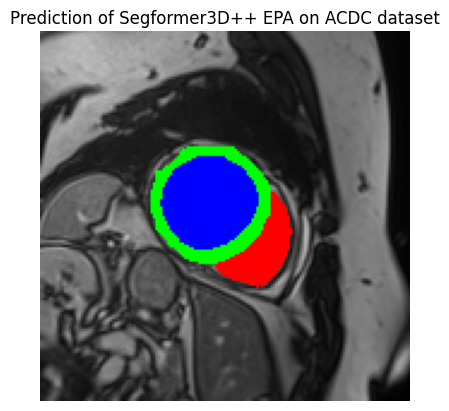

In [28]:
visualize_result(image, prediction, slice_idx = 4, title="Prediction of Segformer3D++ EPA on ACDC dataset")